# Missing Part of the Graph Structure

Using device: cuda
Epoch [10/200], Loss: 0.0967
Epoch [20/200], Loss: 0.0639
Epoch [30/200], Loss: 0.0676
Epoch [40/200], Loss: 0.0519
Epoch [50/200], Loss: 0.0534
Epoch [60/200], Loss: 0.0439
Epoch [70/200], Loss: 0.0441
Epoch [80/200], Loss: 0.0476
Epoch [90/200], Loss: 0.0415
Epoch [100/200], Loss: 0.0460
Epoch [110/200], Loss: 0.0333
Epoch [120/200], Loss: 0.0387
Epoch [130/200], Loss: 0.0512
Epoch [140/200], Loss: 0.0421
Epoch [150/200], Loss: 0.0380
Epoch [160/200], Loss: 0.0417
Epoch [170/200], Loss: 0.0417
Epoch [180/200], Loss: 0.0463
Epoch [190/200], Loss: 0.0365
Epoch [200/200], Loss: 0.0383
Epoch [10/500], Joint Loss: 1.3568, Feature Reconstruction Loss: 1.8327, Neighborhood Reconstruction Loss: 0.8809
Epoch [20/500], Joint Loss: 0.8752, Feature Reconstruction Loss: 1.0364, Neighborhood Reconstruction Loss: 0.7140
Epoch [30/500], Joint Loss: 0.6886, Feature Reconstruction Loss: 0.7505, Neighborhood Reconstruction Loss: 0.6267
Epoch [40/500], Joint Loss: 0.5652, Feature Reco

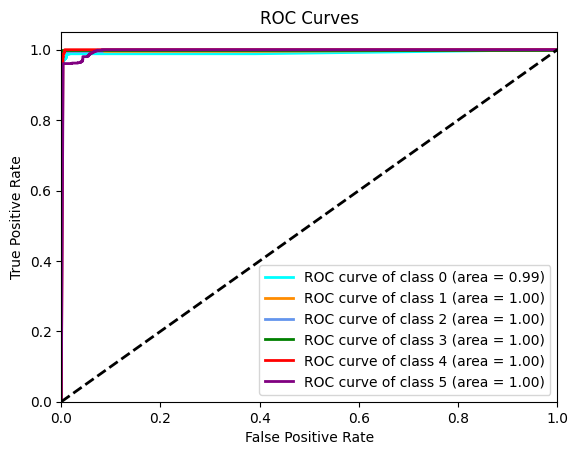

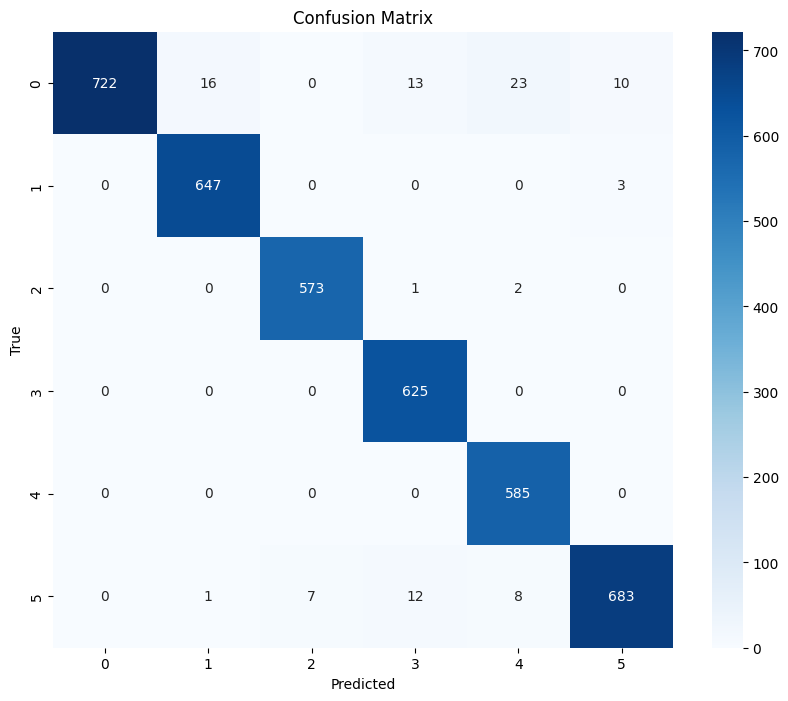

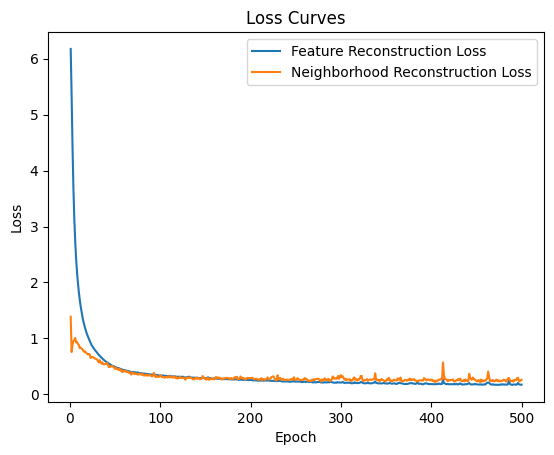

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64
batch_size_ft = 64
num_epochs_ft = 500

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=0.5):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return adj_matrix

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.indices = np.arange(len(features))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.indices[idx]

train_features, test_features, train_labels, test_labels = train_test_split(
    all_features, all_labels.cpu().numpy(), test_size=0.05, random_state=42, stratify=all_labels.cpu().numpy()
)

train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

train_adj = create_adj_matrix(train_labels.cpu().numpy())

train_adj_np = train_adj.copy()
num_edges = int(np.sum(train_adj_np) / 2)
num_disrupt = int(0 * num_edges)

edges = np.array(np.triu_indices(train_adj_np.shape[0], 1)).T
np.random.shuffle(edges)

disrupted_edges = edges[:num_disrupt]

for edge in disrupted_edges:
    train_adj_np[edge[0], edge[1]] = 0
    train_adj_np[edge[1], edge[0]] = 0

train_adj = torch.tensor(train_adj_np, dtype=torch.float32).to(device)

train_dataset = CustomDataset(train_features, train_labels)
train_loader_ft = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_ft, shuffle=True)

joint_losses = []
feature_reconstruction_losses = []
neighborhood_reconstruction_losses = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_joint_loss = 0.0
    running_feature_reconstruction_loss = 0.0
    running_neighborhood_reconstruction_loss = 0.0
    for data, labels, indices in train_loader_ft:
        optimizer_ft.zero_grad()
        z, x_reconstructed, adj_pred = feature_transformer(data)
        batch_adj = train_adj[indices][:, indices]
        joint_loss, feature_reconstruction_loss, neighborhood_reconstruction_loss = joint_loss_function(data, x_reconstructed, batch_adj, adj_pred)
        joint_loss.backward()
        optimizer_ft.step()
        running_joint_loss += joint_loss.item() * data.size(0)
        running_feature_reconstruction_loss += feature_reconstruction_loss.item() * data.size(0)
        running_neighborhood_reconstruction_loss += neighborhood_reconstruction_loss.item() * data.size(0)
    
    avg_joint_loss = running_joint_loss / len(train_loader_ft.dataset)
    avg_feature_reconstruction_loss = running_feature_reconstruction_loss / len(train_loader_ft.dataset)
    avg_neighborhood_reconstruction_loss = running_neighborhood_reconstruction_loss / len(train_loader_ft.dataset)
    joint_losses.append(avg_joint_loss)
    feature_reconstruction_losses.append(avg_feature_reconstruction_loss)
    neighborhood_reconstruction_losses.append(avg_neighborhood_reconstruction_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Joint Loss: {avg_joint_loss:.4f}, Feature Reconstruction Loss: {avg_feature_reconstruction_loss:.4f}, Neighborhood Reconstruction Loss: {avg_neighborhood_reconstruction_loss:.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

with torch.no_grad():
    test_reconstructed_features, _, _ = feature_transformer(test_features)
test_reconstructed_features = test_reconstructed_features.cpu().numpy()

nb_classifier = GaussianNB()
nb_classifier.fit(test_reconstructed_features, test_labels.cpu().numpy())

with torch.no_grad():
    train_reconstructed_features, _, _ = feature_transformer(train_features)
train_reconstructed_features = train_reconstructed_features.cpu().numpy()

train_pred_labels = nb_classifier.predict(train_reconstructed_features)

accuracy = accuracy_score(train_labels.cpu().numpy(), train_pred_labels)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(train_labels.cpu().numpy(), train_pred_labels))

train_labels_binarized = label_binarize(train_labels.cpu().numpy(), classes=np.unique(train_labels.cpu().numpy()))
n_classes = train_labels_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_labels_binarized[:, i], nb_classifier.predict_proba(train_reconstructed_features)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(train_labels.cpu().numpy(), train_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
#plt.plot(range(1, num_epochs_ft + 1), joint_losses, label='Joint Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_reconstruction_losses, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), neighborhood_reconstruction_losses, label='Neighborhood Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# SVM

Using device: cuda
Epoch [10/200], Loss: 0.0937
Epoch [20/200], Loss: 0.0597
Epoch [30/200], Loss: 0.0644
Epoch [40/200], Loss: 0.0543
Epoch [50/200], Loss: 0.0496
Epoch [60/200], Loss: 0.0453
Epoch [70/200], Loss: 0.0610
Epoch [80/200], Loss: 0.0534
Epoch [90/200], Loss: 0.0482
Epoch [100/200], Loss: 0.0373
Epoch [110/200], Loss: 0.0357
Epoch [120/200], Loss: 0.0371
Epoch [130/200], Loss: 0.0395
Epoch [140/200], Loss: 0.0386
Epoch [150/200], Loss: 0.0397
Epoch [160/200], Loss: 0.0421
Epoch [170/200], Loss: 0.0350
Epoch [180/200], Loss: 0.0380
Epoch [190/200], Loss: 0.0379
Epoch [200/200], Loss: 0.0384
Epoch [10/500], Joint Loss: 1.7534, Feature Reconstruction Loss: 1.7506, Neighborhood Reconstruction Loss: 1.7562
Epoch [20/500], Joint Loss: 1.2559, Feature Reconstruction Loss: 0.9940, Neighborhood Reconstruction Loss: 1.5178
Epoch [30/500], Joint Loss: 1.0919, Feature Reconstruction Loss: 0.7040, Neighborhood Reconstruction Loss: 1.4798
Epoch [40/500], Joint Loss: 0.9971, Feature Reco

C:\Users\Qishan\anaconda3\envs\exam\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Qishan\anaconda3\envs\exam\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Qishan\anaconda3\envs\exam\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


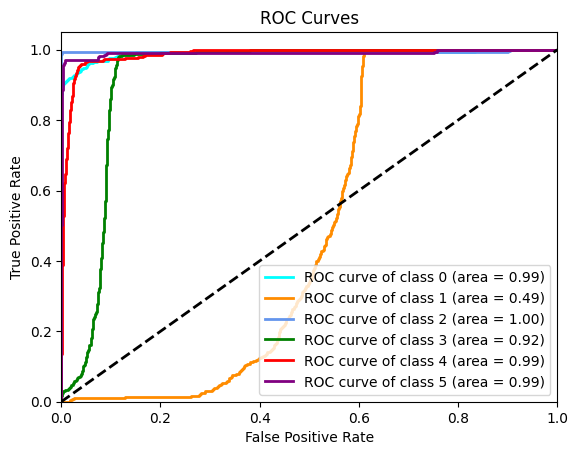

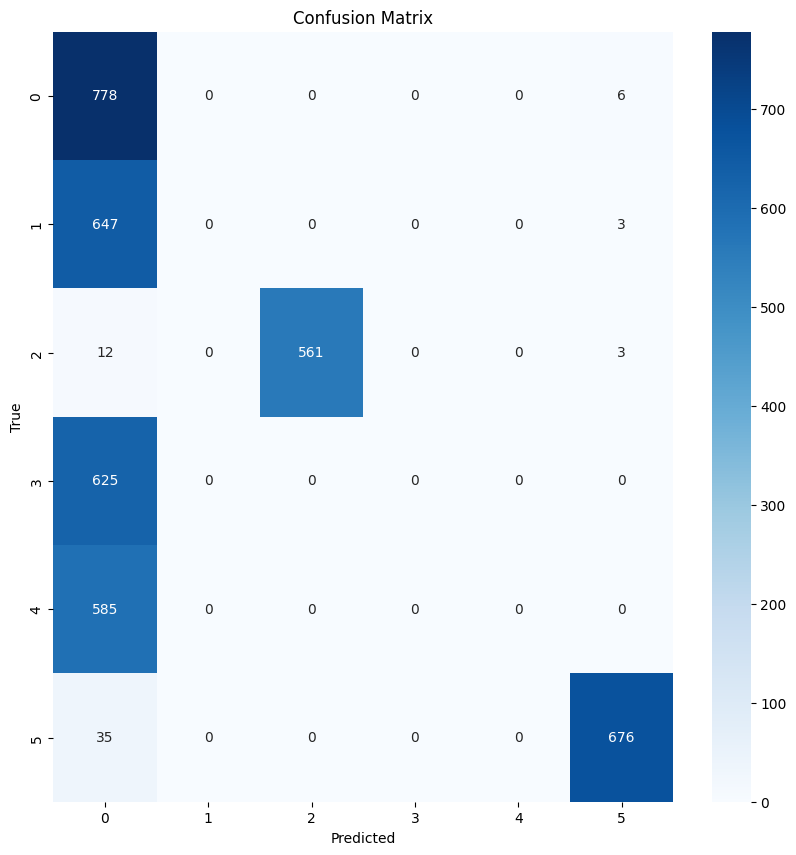

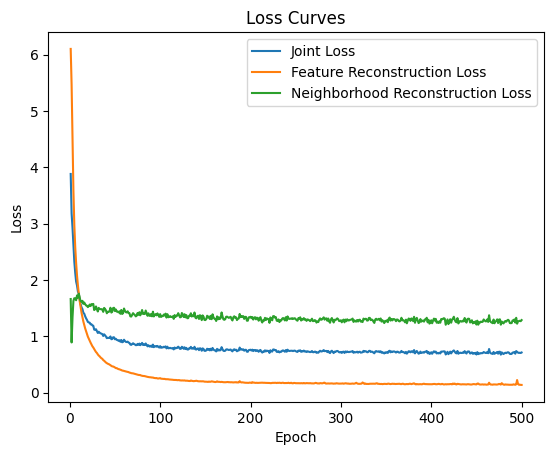

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64
batch_size_ft = 64
num_epochs_ft = 500

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=0.5):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return adj_matrix

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.indices = np.arange(len(features))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.indices[idx]

train_features, test_features, train_labels, test_labels = train_test_split(
    all_features, all_labels.cpu().numpy(), test_size=0.05, random_state=42, stratify=all_labels.cpu().numpy()
)

train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

train_adj = create_adj_matrix(train_labels.cpu().numpy())

train_adj_np = train_adj.copy()
num_edges = int(np.sum(train_adj_np) / 2)
num_disrupt = int(1 * num_edges)

edges = np.array(np.triu_indices(train_adj_np.shape[0], 1)).T
np.random.shuffle(edges)

disrupted_edges = edges[:num_disrupt]

for edge in disrupted_edges:
    train_adj_np[edge[0], edge[1]] = 0
    train_adj_np[edge[1], edge[0]] = 0

train_adj = torch.tensor(train_adj_np, dtype=torch.float32).to(device)

train_dataset = CustomDataset(train_features, train_labels)
train_loader_ft = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_ft, shuffle=True)

joint_losses = []
feature_reconstruction_losses = []
neighborhood_reconstruction_losses = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_joint_loss = 0.0
    running_feature_reconstruction_loss = 0.0
    running_neighborhood_reconstruction_loss = 0.0
    for data, labels, indices in train_loader_ft:
        optimizer_ft.zero_grad()
        z, x_reconstructed, adj_pred = feature_transformer(data)
        batch_adj = train_adj[indices][:, indices]
        joint_loss, feature_reconstruction_loss, neighborhood_reconstruction_loss = joint_loss_function(data, x_reconstructed, batch_adj, adj_pred)
        joint_loss.backward()
        optimizer_ft.step()
        running_joint_loss += joint_loss.item() * data.size(0)
        running_feature_reconstruction_loss += feature_reconstruction_loss.item() * data.size(0)
        running_neighborhood_reconstruction_loss += neighborhood_reconstruction_loss.item() * data.size(0)
    
    avg_joint_loss = running_joint_loss / len(train_loader_ft.dataset)
    avg_feature_reconstruction_loss = running_feature_reconstruction_loss / len(train_loader_ft.dataset)
    avg_neighborhood_reconstruction_loss = running_neighborhood_reconstruction_loss / len(train_loader_ft.dataset)
    joint_losses.append(avg_joint_loss)
    feature_reconstruction_losses.append(avg_feature_reconstruction_loss)
    neighborhood_reconstruction_losses.append(avg_neighborhood_reconstruction_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Joint Loss: {avg_joint_loss:.4f}, Feature Reconstruction Loss: {avg_feature_reconstruction_loss:.4f}, Neighborhood Reconstruction Loss: {avg_neighborhood_reconstruction_loss:.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

with torch.no_grad():
    test_reconstructed_features, _, _ = feature_transformer(test_features)
test_reconstructed_features = test_reconstructed_features.cpu().numpy()

svm_classifier = SVC(probability=True)
svm_classifier.fit(test_reconstructed_features, test_labels.cpu().numpy())

with torch.no_grad():
    train_reconstructed_features, _, _ = feature_transformer(train_features)
train_reconstructed_features = train_reconstructed_features.cpu().numpy()

train_pred_labels = svm_classifier.predict(train_reconstructed_features)

accuracy = accuracy_score(train_labels.cpu().numpy(), train_pred_labels)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(train_labels.cpu().numpy(), train_pred_labels))

train_labels_binarized = label_binarize(train_labels.cpu().numpy(), classes=np.unique(train_labels.cpu().numpy()))
n_classes = train_labels_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_labels_binarized[:, i], svm_classifier.predict_proba(train_reconstructed_features)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(train_labels.cpu().numpy(), train_pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
plt.plot(range(1, num_epochs_ft + 1), joint_losses, label='Joint Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_reconstruction_losses, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), neighborhood_reconstruction_losses, label='Neighborhood Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# KNN

Using device: cuda
Epoch [10/200], Loss: 0.0868
Epoch [20/200], Loss: 0.0629
Epoch [30/200], Loss: 0.0539
Epoch [40/200], Loss: 0.0567
Epoch [50/200], Loss: 0.0444
Epoch [60/200], Loss: 0.0574
Epoch [70/200], Loss: 0.0534
Epoch [80/200], Loss: 0.0465
Epoch [90/200], Loss: 0.0526
Epoch [100/200], Loss: 0.0421
Epoch [110/200], Loss: 0.0458
Epoch [120/200], Loss: 0.0445
Epoch [130/200], Loss: 0.0381
Epoch [140/200], Loss: 0.0344
Epoch [150/200], Loss: 0.0397
Epoch [160/200], Loss: 0.0380
Epoch [170/200], Loss: 0.0348
Epoch [180/200], Loss: 0.0395
Epoch [190/200], Loss: 0.0385
Epoch [200/200], Loss: 0.0319
Epoch [10/500], Joint Loss: 1.6711, Feature Reconstruction Loss: 1.7068, Neighborhood Reconstruction Loss: 1.6353
Epoch [20/500], Joint Loss: 1.2641, Feature Reconstruction Loss: 0.9736, Neighborhood Reconstruction Loss: 1.5547
Epoch [30/500], Joint Loss: 1.0838, Feature Reconstruction Loss: 0.6747, Neighborhood Reconstruction Loss: 1.4929
Epoch [40/500], Joint Loss: 0.9694, Feature Reco

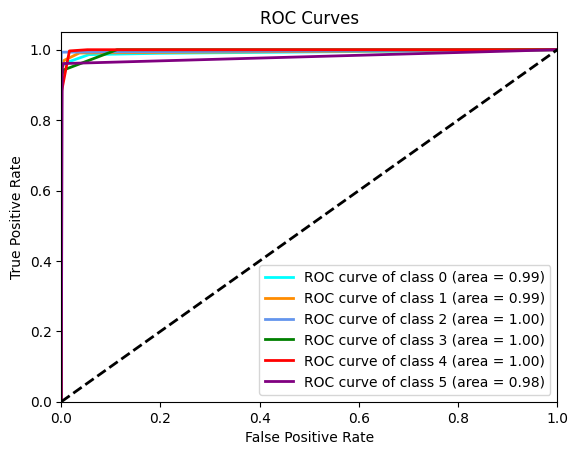

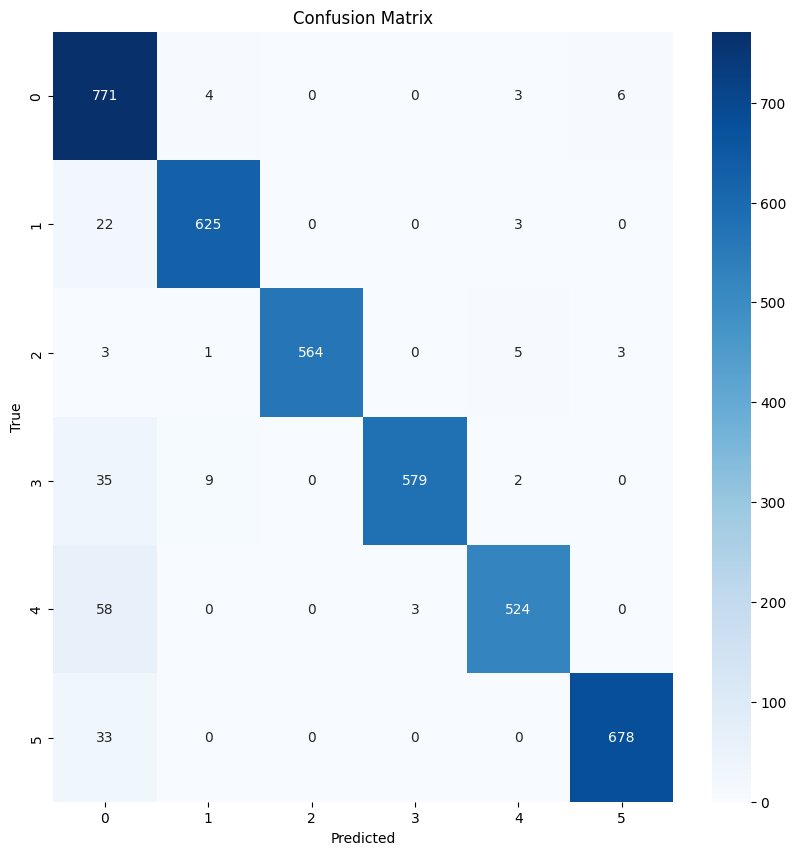

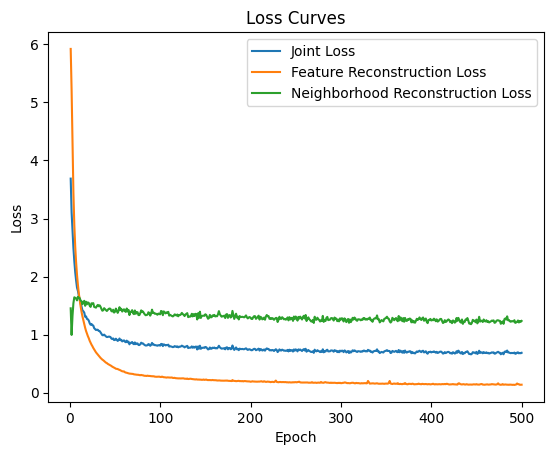

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64
batch_size_ft = 64
num_epochs_ft = 500

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=0.5):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return adj_matrix

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.indices = np.arange(len(features))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.indices[idx]

train_features, test_features, train_labels, test_labels = train_test_split(
    all_features, all_labels.cpu().numpy(), test_size=0.05, random_state=42, stratify=all_labels.cpu().numpy()
)

train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

train_adj = create_adj_matrix(train_labels.cpu().numpy())

train_adj_np = train_adj.copy()
num_edges = int(np.sum(train_adj_np) / 2)
num_disrupt = int(1 * num_edges)

edges = np.array(np.triu_indices(train_adj_np.shape[0], 1)).T
np.random.shuffle(edges)

disrupted_edges = edges[:num_disrupt]

for edge in disrupted_edges:
    train_adj_np[edge[0], edge[1]] = 0
    train_adj_np[edge[1], edge[0]] = 0

train_adj = torch.tensor(train_adj_np, dtype=torch.float32).to(device)

train_dataset = CustomDataset(train_features, train_labels)
train_loader_ft = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_ft, shuffle=True)

joint_losses = []
feature_reconstruction_losses = []
neighborhood_reconstruction_losses = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_joint_loss = 0.0
    running_feature_reconstruction_loss = 0.0
    running_neighborhood_reconstruction_loss = 0.0
    for data, labels, indices in train_loader_ft:
        optimizer_ft.zero_grad()
        z, x_reconstructed, adj_pred = feature_transformer(data)
        batch_adj = train_adj[indices][:, indices]
        joint_loss, feature_reconstruction_loss, neighborhood_reconstruction_loss = joint_loss_function(data, x_reconstructed, batch_adj, adj_pred)
        joint_loss.backward()
        optimizer_ft.step()
        running_joint_loss += joint_loss.item() * data.size(0)
        running_feature_reconstruction_loss += feature_reconstruction_loss.item() * data.size(0)
        running_neighborhood_reconstruction_loss += neighborhood_reconstruction_loss.item() * data.size(0)
    
    avg_joint_loss = running_joint_loss / len(train_loader_ft.dataset)
    avg_feature_reconstruction_loss = running_feature_reconstruction_loss / len(train_loader_ft.dataset)
    avg_neighborhood_reconstruction_loss = running_neighborhood_reconstruction_loss / len(train_loader_ft.dataset)
    joint_losses.append(avg_joint_loss)
    feature_reconstruction_losses.append(avg_feature_reconstruction_loss)
    neighborhood_reconstruction_losses.append(avg_neighborhood_reconstruction_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Joint Loss: {avg_joint_loss:.4f}, Feature Reconstruction Loss: {avg_feature_reconstruction_loss:.4f}, Neighborhood Reconstruction Loss: {avg_neighborhood_reconstruction_loss:.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

with torch.no_grad():
    test_reconstructed_features, _, _ = feature_transformer(test_features)
test_reconstructed_features = test_reconstructed_features.cpu().numpy()

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(test_reconstructed_features, test_labels.cpu().numpy())

with torch.no_grad():
    train_reconstructed_features, _, _ = feature_transformer(train_features)
train_reconstructed_features = train_reconstructed_features.cpu().numpy()

train_pred_labels = knn_classifier.predict(train_reconstructed_features)

accuracy = accuracy_score(train_labels.cpu().numpy(), train_pred_labels)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(train_labels.cpu().numpy(), train_pred_labels))

train_labels_binarized = label_binarize(train_labels.cpu().numpy(), classes=np.unique(train_labels.cpu().numpy()))
n_classes = train_labels_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_labels_binarized[:, i], knn_classifier.predict_proba(train_reconstructed_features)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(train_labels.cpu().numpy(), train_pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
plt.plot(range(1, num_epochs_ft + 1), joint_losses, label='Joint Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_reconstruction_losses, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), neighborhood_reconstruction_losses, label='Neighborhood Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


# RF

Using device: cuda
Epoch [10/200], Loss: 0.0989
Epoch [20/200], Loss: 0.0592
Epoch [30/200], Loss: 0.0585
Epoch [40/200], Loss: 0.0502
Epoch [50/200], Loss: 0.0518
Epoch [60/200], Loss: 0.0458
Epoch [70/200], Loss: 0.0456
Epoch [80/200], Loss: 0.0415
Epoch [90/200], Loss: 0.0383
Epoch [100/200], Loss: 0.0401
Epoch [110/200], Loss: 0.0412
Epoch [120/200], Loss: 0.0415
Epoch [130/200], Loss: 0.0377
Epoch [140/200], Loss: 0.0335
Epoch [150/200], Loss: 0.0439
Epoch [160/200], Loss: 0.0399
Epoch [170/200], Loss: 0.0423
Epoch [180/200], Loss: 0.0370
Epoch [190/200], Loss: 0.0338
Epoch [200/200], Loss: 0.0388
Epoch [10/500], Joint Loss: 1.6686, Feature Reconstruction Loss: 1.6437, Neighborhood Reconstruction Loss: 1.6935
Epoch [20/500], Joint Loss: 1.2524, Feature Reconstruction Loss: 0.9393, Neighborhood Reconstruction Loss: 1.5656
Epoch [30/500], Joint Loss: 1.0676, Feature Reconstruction Loss: 0.6468, Neighborhood Reconstruction Loss: 1.4884
Epoch [40/500], Joint Loss: 0.9633, Feature Reco

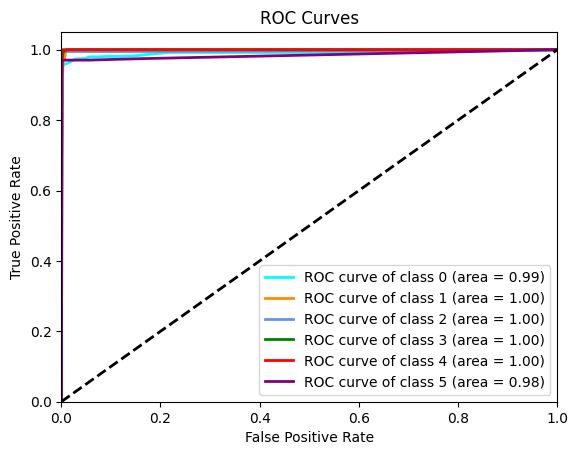

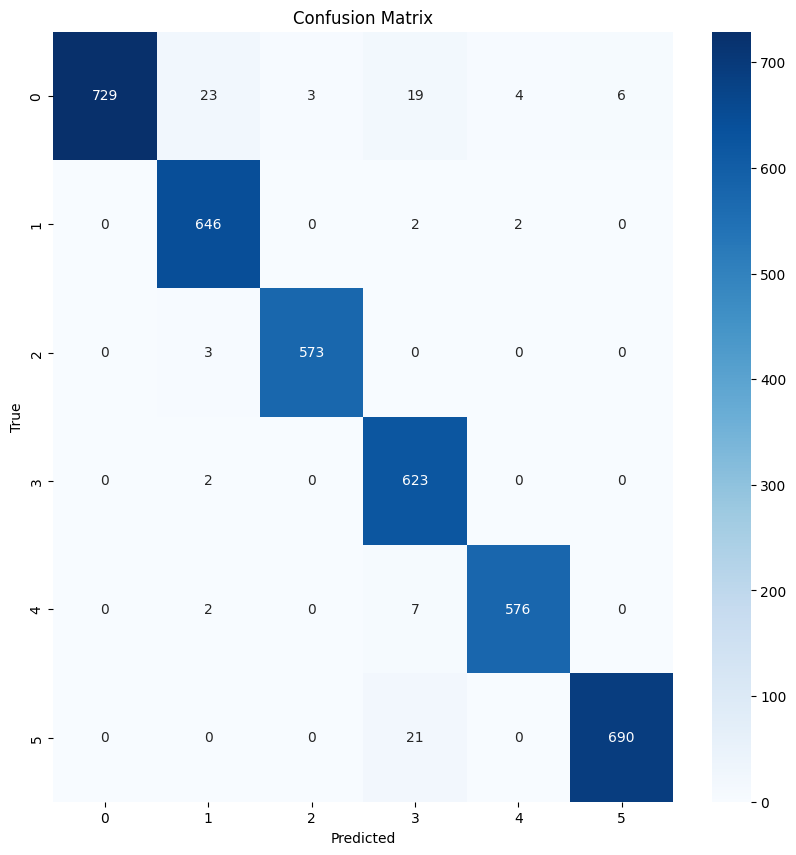

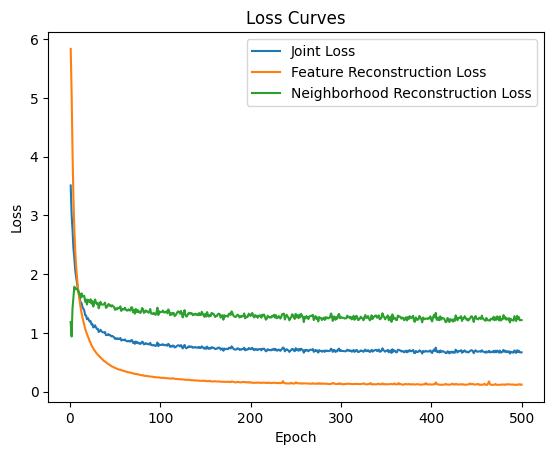

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

data_dict = np.load('dataset.npy', allow_pickle=True).item()
all_frames = data_dict['frames']
all_labels = data_dict['labels']

scaler = StandardScaler()
num_samples, num_timesteps, num_features = all_frames.shape
all_frames = all_frames.reshape(num_samples * num_timesteps, num_features)
all_frames = scaler.fit_transform(all_frames)
all_frames = all_frames.reshape(num_samples, num_timesteps, num_features)

all_frames = torch.tensor(all_frames, dtype=torch.float32).to(device)
all_labels = torch.tensor(all_labels, dtype=torch.long).to(device)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)

input_dim = num_timesteps * num_features
encoding_dim = 64
learning_rate = 0.001
num_epochs_ae = 200
batch_size = 32

autoencoder = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=learning_rate)

train_loader = torch.utils.data.DataLoader(all_frames, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for data in train_loader:
        data = data.view(data.size(0), -1)
        optimizer_ae.zero_grad()
        output = autoencoder(data)
        loss = criterion_ae(output, data)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * data.size(0)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ae}], Loss: {running_loss / len(train_loader.dataset):.4f}')

for param in autoencoder.parameters():
    param.requires_grad = False

all_features = autoencoder.encode(all_frames.view(all_frames.size(0), -1)).detach().cpu().numpy()

class MLPEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FeatureDecoder, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)

    def forward(self, z):
        return self.fc(z)

class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        adj_pred = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_pred

class FeatureTransformer(nn.Module):
    def __init__(self, encoder, feature_decoder, adj_decoder):
        super(FeatureTransformer, self).__init__()
        self.encoder = encoder
        self.feature_decoder = feature_decoder
        self.adj_decoder = adj_decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.feature_decoder(z)
        adj_pred = self.adj_decoder(z)
        return z, x_reconstructed, adj_pred

input_dim_ft = encoding_dim
hidden_dim_ft = 64
output_dim_ft = 64
batch_size_ft = 64
num_epochs_ft = 500

mlp_encoder = MLPEncoder(input_dim_ft, hidden_dim_ft, output_dim_ft).to(device)
feature_decoder = FeatureDecoder(output_dim_ft, input_dim_ft).to(device)
adj_decoder = InnerProductDecoder().to(device)

feature_transformer = FeatureTransformer(mlp_encoder, feature_decoder, adj_decoder).to(device)
optimizer_ft = optim.Adam(feature_transformer.parameters(), lr=learning_rate)

def joint_loss_function(x, x_reconstructed, adj, adj_pred, alpha=0.5):
    feature_reconstruction_loss = F.mse_loss(x_reconstructed, x)
    adj_reconstruction_loss = F.binary_cross_entropy(adj_pred, adj)
    loss = alpha * feature_reconstruction_loss + (1 - alpha) * adj_reconstruction_loss
    return loss, feature_reconstruction_loss, adj_reconstruction_loss

def create_adj_matrix(labels):
    num_samples = len(labels)
    adj_matrix = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(num_samples):
            if labels[i] == labels[j]:
                adj_matrix[i, j] = 1
    return adj_matrix

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.indices = np.arange(len(features))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.indices[idx]

train_features, test_features, train_labels, test_labels = train_test_split(
    all_features, all_labels.cpu().numpy(), test_size=0.05, random_state=42, stratify=all_labels.cpu().numpy()
)

train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

train_adj = create_adj_matrix(train_labels.cpu().numpy())

train_adj_np = train_adj.copy()
num_edges = int(np.sum(train_adj_np) / 2)
num_disrupt = int(1 * num_edges)

edges = np.array(np.triu_indices(train_adj_np.shape[0], 1)).T
np.random.shuffle(edges)

disrupted_edges = edges[:num_disrupt]

for edge in disrupted_edges:
    train_adj_np[edge[0], edge[1]] = 0
    train_adj_np[edge[1], edge[0]] = 0

train_adj = torch.tensor(train_adj_np, dtype=torch.float32).to(device)

train_dataset = CustomDataset(train_features, train_labels)
train_loader_ft = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_ft, shuffle=True)

joint_losses = []
feature_reconstruction_losses = []
neighborhood_reconstruction_losses = []

for epoch in range(num_epochs_ft):
    feature_transformer.train()
    running_joint_loss = 0.0
    running_feature_reconstruction_loss = 0.0
    running_neighborhood_reconstruction_loss = 0.0
    for data, labels, indices in train_loader_ft:
        optimizer_ft.zero_grad()
        z, x_reconstructed, adj_pred = feature_transformer(data)
        batch_adj = train_adj[indices][:, indices]
        joint_loss, feature_reconstruction_loss, neighborhood_reconstruction_loss = joint_loss_function(data, x_reconstructed, batch_adj, adj_pred)
        joint_loss.backward()
        optimizer_ft.step()
        running_joint_loss += joint_loss.item() * data.size(0)
        running_feature_reconstruction_loss += feature_reconstruction_loss.item() * data.size(0)
        running_neighborhood_reconstruction_loss += neighborhood_reconstruction_loss.item() * data.size(0)
    
    avg_joint_loss = running_joint_loss / len(train_loader_ft.dataset)
    avg_feature_reconstruction_loss = running_feature_reconstruction_loss / len(train_loader_ft.dataset)
    avg_neighborhood_reconstruction_loss = running_neighborhood_reconstruction_loss / len(train_loader_ft.dataset)
    joint_losses.append(avg_joint_loss)
    feature_reconstruction_losses.append(avg_feature_reconstruction_loss)
    neighborhood_reconstruction_losses.append(avg_neighborhood_reconstruction_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs_ft}], Joint Loss: {avg_joint_loss:.4f}, Feature Reconstruction Loss: {avg_feature_reconstruction_loss:.4f}, Neighborhood Reconstruction Loss: {avg_neighborhood_reconstruction_loss:.4f}')

for param in feature_transformer.parameters():
    param.requires_grad = False

with torch.no_grad():
    test_reconstructed_features, _, _ = feature_transformer(test_features)
test_reconstructed_features = test_reconstructed_features.cpu().numpy()

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(test_reconstructed_features, test_labels.cpu().numpy())

with torch.no_grad():
    train_reconstructed_features, _, _ = feature_transformer(train_features)
train_reconstructed_features = train_reconstructed_features.cpu().numpy()

train_pred_labels = rf_classifier.predict(train_reconstructed_features)

accuracy = accuracy_score(train_labels.cpu().numpy(), train_pred_labels)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(train_labels.cpu().numpy(), train_pred_labels))

train_labels_binarized = label_binarize(train_labels.cpu().numpy(), classes=np.unique(train_labels.cpu().numpy()))
n_classes = train_labels_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_labels_binarized[:, i], rf_classifier.predict_proba(train_reconstructed_features)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

conf_matrix = confusion_matrix(train_labels.cpu().numpy(), train_pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
plt.plot(range(1, num_epochs_ft + 1), joint_losses, label='Joint Loss')
plt.plot(range(1, num_epochs_ft + 1), feature_reconstruction_losses, label='Feature Reconstruction Loss')
plt.plot(range(1, num_epochs_ft + 1), neighborhood_reconstruction_losses, label='Neighborhood Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()
